In [3]:
import sys
sys.path.insert(0, 'drnet-py/')
import numpy as np
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch.optim import Adam
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from PIL import Image
from io import  BytesIO
import IPython.display


import random
import os
from scipy import misc
from Colorferet import Colorferet
import utils

import models.resnet_128 as resnet_models
import models.dcgan_128 as dcgan_models
import models.dcgan_unet_128 as dcgan_unet_models
import models.vgg_unet_128 as vgg_unet_models
import models.classifiers as classifiers


In [4]:
num_epoch = 60
epoch_size = 50
batch_size = 100

img_size = 128
num_channel = 3
lr = 0.002
momentum = 0.9
beta1 = 0.9
num_layers_classifier = 100


pose_dim = 20
content_dim = 100
adverserial_loss_weight = 1



In [5]:
netEC = vgg_unet_models.content_encoder(content_dim, num_channel).cuda()
netEP = resnet_models.pose_encoder(pose_dim, num_channel, normalize= False).cuda()
netD = vgg_unet_models.decoder(content_dim, pose_dim, num_channel).cuda()
netC = classifiers.scene_discriminator(pose_dim, num_layers_classifier).cuda()

netEC.apply(utils.init_weights)
netEP.apply(utils.init_weights)
netD.apply(utils.init_weights)
netC.apply(utils.init_weights)
print('Init weights')

Init weights


In [6]:
optimizerC = Adam(netC.parameters(), lr=lr, betas=(beta1, momentum))
optimizerEC = Adam(netEC.parameters(), lr=lr, betas=(beta1, momentum))
optimizerEP = Adam(netEP.parameters(), lr=lr, betas=(beta1, momentum))
optimizerD = Adam(netD.parameters(), lr=lr, betas=(beta1, momentum))

mse_criterion = nn.MSELoss().cuda()
bce_criterion = nn.BCELoss().cuda()

train_data = Colorferet(train=True)
test_data = Colorferet(train=False)

train_loader = DataLoader(train_data,num_workers=4, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data,num_workers=4,batch_size=batch_size, shuffle=True, drop_last=True)

/share/apps/python3/3.5.3/intel/lib/python3.5/site-packages/scikit_image-0.13.1-py3.5-linux-x86_64.egg/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [7]:
def get_training_batch():
    while True:
        for sequence in train_loader:
            sequence.transpose_(0, 1)
            sequence.transpose_(3, 4).transpose_(2, 3)
            batch = [Variable(x) for x in sequence]
            yield batch
            
            
def get_testing_batch():
    while True:
        for sequence in test_loader:
            sequence.transpose_(0, 1)
            sequence.transpose_(3, 4).transpose_(2, 3)
            batch = [Variable(x) for x in sequence]
            yield batch

In [8]:
training_batch_generator = get_training_batch()
testing_batch_generator = get_testing_batch()

In [9]:
def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = BytesIO()
    Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

In [10]:
def train(x):
    netEP.zero_grad()
    netEC.zero_grad()
    netD.zero_grad()

    x_c1 = x[0].float().cuda()
    x_c2 = x[1].float().cuda()
    x_p1 = x[2].float().cuda()
    x_p2 = x[3].float().cuda()

    h_c1 = netEC(x_c1)
    h_c2 = netEC(x_c2)[0].detach()
    h_p1 = netEP(x_p1) # used for scene discriminator
    h_p2 = netEP(x_p2).detach()
    

    # similarity loss: ||h_c1 - h_c2||
    sim_loss = mse_criterion(h_c1[0], h_c2)


    # reconstruction loss: ||D(h_c1, h_p1), x_p1|| 
    rec = netD([h_c1, h_p1])
    rec_loss = mse_criterion(rec, x_p1)
    
    x_c1_print = x_c1[0,:,:,:].data.cpu().numpy().transpose(1,2,0)*255.
    x_p1_print = x_p1[0,:,:,:].data.cpu().numpy().transpose(1,2,0)*255.
    rec_print = rec[0,:,:,:].data.cpu().numpy().transpose(1,2,0)*255.

    showarray(x_c1_print)
    showarray(x_p1_print)
    showarray(rec_print)
    
    # scene discriminator loss: maximize entropy of output
    target = torch.cuda.FloatTensor(batch_size, 1).fill_(0.5)
    out = netC([h_p1, h_p2])
    sd_loss = bce_criterion(out, Variable(target))

    # full loss
    loss = sim_loss + rec_loss + adverserial_loss_weight * sd_loss
    loss.backward()

    optimizerEC.step()
    optimizerEP.step()
    optimizerD.step()

    return sim_loss.data.cpu().numpy(), rec_loss.data.cpu().numpy() 

def train_scene_discriminator(x):
    netC.zero_grad()

    target = torch.cuda.FloatTensor(batch_size, 1)

    x1 = x[0].float().cuda()
    x2 = x[1].float().cuda()
    h_p1 = netEP(x1).detach()
    h_p2 = netEP(x2).detach()

    half = int(batch_size/2)
    rp = torch.randperm(half).cuda()
    h_p2[:half] = h_p2[rp]
    target[:half] = 1
    target[half:] = 0
    out = netC([h_p1, h_p2])
    bce = bce_criterion(out, Variable(target))

    bce.backward()
    optimizerC.step()

    acc = out[:half].gt(0.5).sum() + out[half:].le(0.5).sum()
    return bce.data.cpu().numpy(), acc.data.cpu().numpy()/batch_size

/share/apps/pytorch/0.2.0_3/python3.5/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:135: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.")


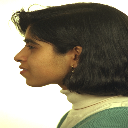

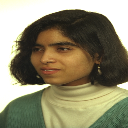

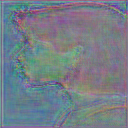

[00] rec loss: 0.0024 | sim loss: 0.0109 | scene disc acc: 1.040% (0)


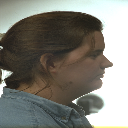

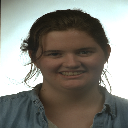

[01] rec loss: 0.0016 | sim loss: 0.0069 | scene disc acc: 1.000% (5000)


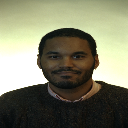

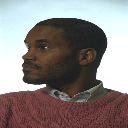

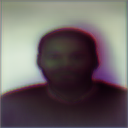

[02] rec loss: 0.0014 | sim loss: 0.0037 | scene disc acc: 0.960% (10000)


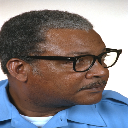

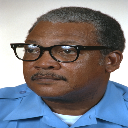

[03] rec loss: 0.0015 | sim loss: 0.0043 | scene disc acc: 1.060% (15000)


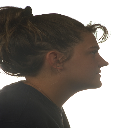

[04] rec loss: 0.0014 | sim loss: 0.0072 | scene disc acc: 1.140% (20000)


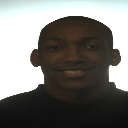

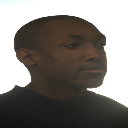

[05] rec loss: 0.0014 | sim loss: 0.0023 | scene disc acc: 1.300% (25000)


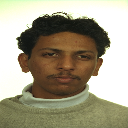

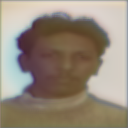

[06] rec loss: 0.0013 | sim loss: 0.0033 | scene disc acc: 1.300% (30000)


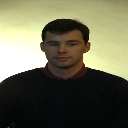

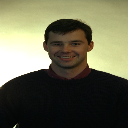

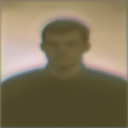

[07] rec loss: 0.0014 | sim loss: 0.0026 | scene disc acc: 1.260% (35000)


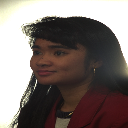

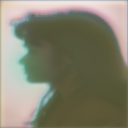

[08] rec loss: 0.0015 | sim loss: 0.0022 | scene disc acc: 1.200% (40000)


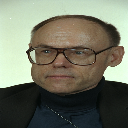

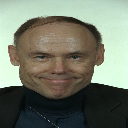

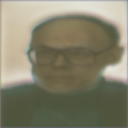

[09] rec loss: 0.0013 | sim loss: 0.0022 | scene disc acc: 1.240% (45000)


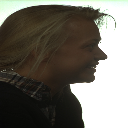

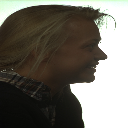

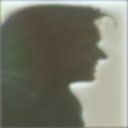

[10] rec loss: 0.0014 | sim loss: 0.0025 | scene disc acc: 1.100% (50000)


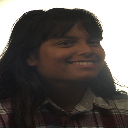

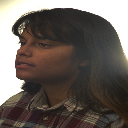

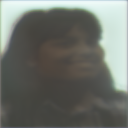

[11] rec loss: 0.0013 | sim loss: 0.0026 | scene disc acc: 1.320% (55000)


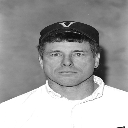

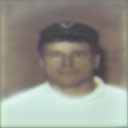

[12] rec loss: 0.0015 | sim loss: 0.0050 | scene disc acc: 0.860% (60000)


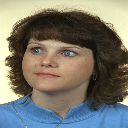

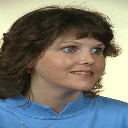

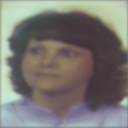

[13] rec loss: 0.0014 | sim loss: 0.0020 | scene disc acc: 1.080% (65000)


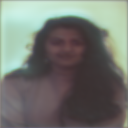

[14] rec loss: 0.0013 | sim loss: 0.0011 | scene disc acc: 0.980% (70000)


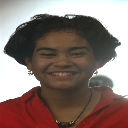

[15] rec loss: 0.0014 | sim loss: 0.0024 | scene disc acc: 1.160% (75000)


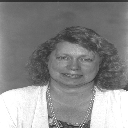

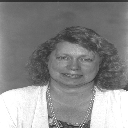

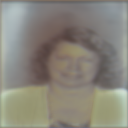

[16] rec loss: 0.0012 | sim loss: 0.0013 | scene disc acc: 1.080% (80000)


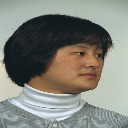

[17] rec loss: 0.0012 | sim loss: 0.0027 | scene disc acc: 0.980% (85000)


[18] rec loss: 0.0011 | sim loss: 0.0025 | scene disc acc: 1.040% (90000)


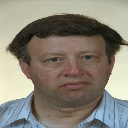

[19] rec loss: 0.0012 | sim loss: 0.0022 | scene disc acc: 1.160% (95000)


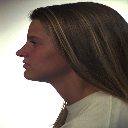

[20] rec loss: 0.0010 | sim loss: 0.0016 | scene disc acc: 1.180% (100000)


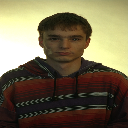

[21] rec loss: 0.0012 | sim loss: 0.0030 | scene disc acc: 1.040% (105000)


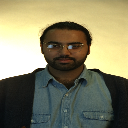

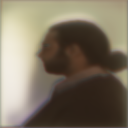

[22] rec loss: 0.0010 | sim loss: 0.0020 | scene disc acc: 1.020% (110000)


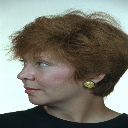

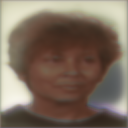

[23] rec loss: 0.0011 | sim loss: 0.0026 | scene disc acc: 1.140% (115000)


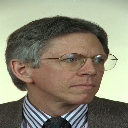

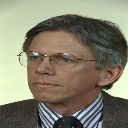

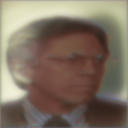

[24] rec loss: 0.0011 | sim loss: 0.0014 | scene disc acc: 1.200% (120000)


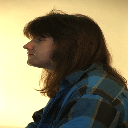

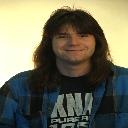

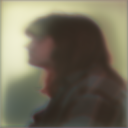

[25] rec loss: 0.0010 | sim loss: 0.0024 | scene disc acc: 0.960% (125000)


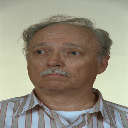

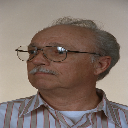

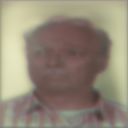

[26] rec loss: 0.0008 | sim loss: 0.0019 | scene disc acc: 1.080% (130000)


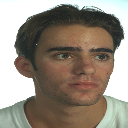

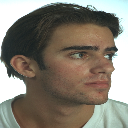

[27] rec loss: 0.0010 | sim loss: 0.0017 | scene disc acc: 1.300% (135000)


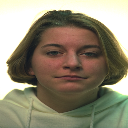

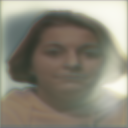

[28] rec loss: 0.0009 | sim loss: 0.0019 | scene disc acc: 1.200% (140000)


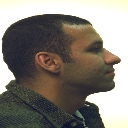

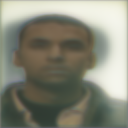

[29] rec loss: 0.0009 | sim loss: 0.0016 | scene disc acc: 1.280% (145000)


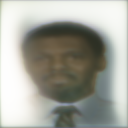

[30] rec loss: 0.0009 | sim loss: 0.0035 | scene disc acc: 1.180% (150000)


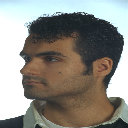

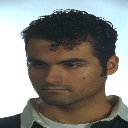

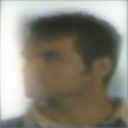

[31] rec loss: 0.0009 | sim loss: 0.0022 | scene disc acc: 1.080% (155000)


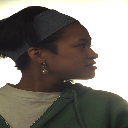

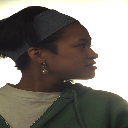

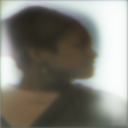

[32] rec loss: 0.0009 | sim loss: 0.0015 | scene disc acc: 1.320% (160000)


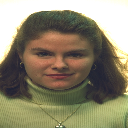

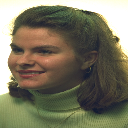

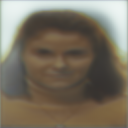

[33] rec loss: 0.0008 | sim loss: 0.0012 | scene disc acc: 1.180% (165000)


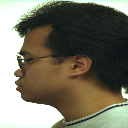

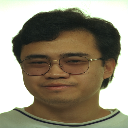

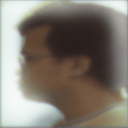

[34] rec loss: 0.0009 | sim loss: 0.0016 | scene disc acc: 1.100% (170000)


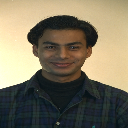

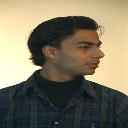

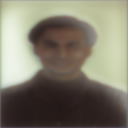

[35] rec loss: 0.0008 | sim loss: 0.0012 | scene disc acc: 1.240% (175000)


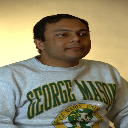

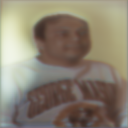

[36] rec loss: 0.0007 | sim loss: 0.0013 | scene disc acc: 1.160% (180000)


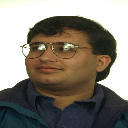

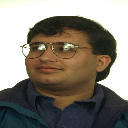

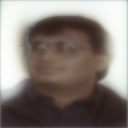

[37] rec loss: 0.0008 | sim loss: 0.0016 | scene disc acc: 1.320% (185000)


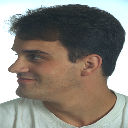

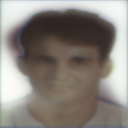

[38] rec loss: 0.0008 | sim loss: 0.0019 | scene disc acc: 1.360% (190000)


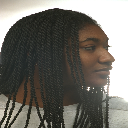

[39] rec loss: 0.0008 | sim loss: 0.0017 | scene disc acc: 1.300% (195000)


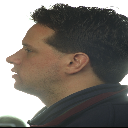

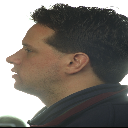

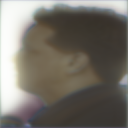

[40] rec loss: 0.0007 | sim loss: 0.0011 | scene disc acc: 1.240% (200000)


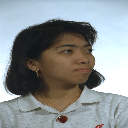

[41] rec loss: 0.0008 | sim loss: 0.0027 | scene disc acc: 1.200% (205000)


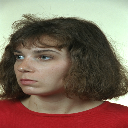

[42] rec loss: 0.0008 | sim loss: 0.0010 | scene disc acc: 1.220% (210000)


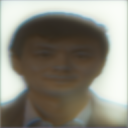

[43] rec loss: 0.0008 | sim loss: 0.0022 | scene disc acc: 1.260% (215000)


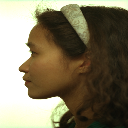

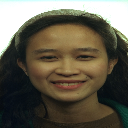

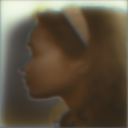

[44] rec loss: 0.0008 | sim loss: 0.0034 | scene disc acc: 1.180% (220000)


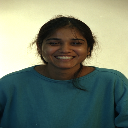

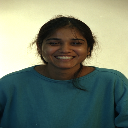

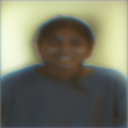

[45] rec loss: 0.0008 | sim loss: 0.0017 | scene disc acc: 1.240% (225000)


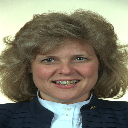

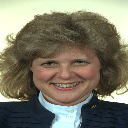

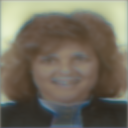

[46] rec loss: 0.0007 | sim loss: 0.0014 | scene disc acc: 1.260% (230000)


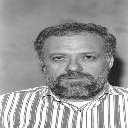

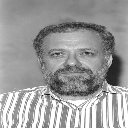

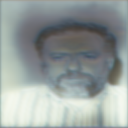

[47] rec loss: 0.0008 | sim loss: 0.0011 | scene disc acc: 1.340% (235000)


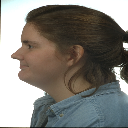

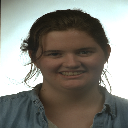

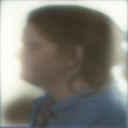

[48] rec loss: 0.0008 | sim loss: 0.0013 | scene disc acc: 1.380% (240000)


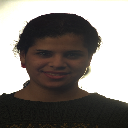

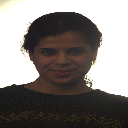

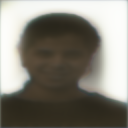

[49] rec loss: 0.0007 | sim loss: 0.0006 | scene disc acc: 1.380% (245000)


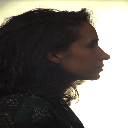

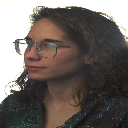

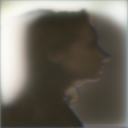

[50] rec loss: 0.0008 | sim loss: 0.0010 | scene disc acc: 1.160% (250000)


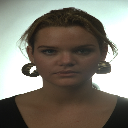

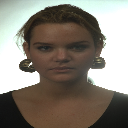

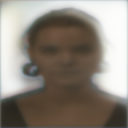

[51] rec loss: 0.0008 | sim loss: 0.0015 | scene disc acc: 1.320% (255000)


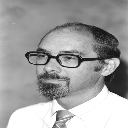

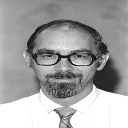

[52] rec loss: 0.0009 | sim loss: 0.0011 | scene disc acc: 1.380% (260000)


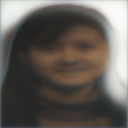

[53] rec loss: 0.0007 | sim loss: 0.0028 | scene disc acc: 1.160% (265000)


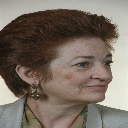

[54] rec loss: 0.0008 | sim loss: 0.0015 | scene disc acc: 1.080% (270000)


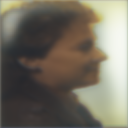

[55] rec loss: 0.0008 | sim loss: 0.0018 | scene disc acc: 1.120% (275000)


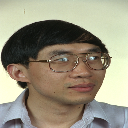

[56] rec loss: 0.0008 | sim loss: 0.0011 | scene disc acc: 1.420% (280000)


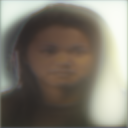

[57] rec loss: 0.0008 | sim loss: 0.0015 | scene disc acc: 1.140% (285000)


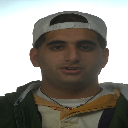

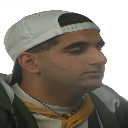

[58] rec loss: 0.0008 | sim loss: 0.0006 | scene disc acc: 1.220% (290000)


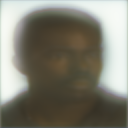

[59] rec loss: 0.0009 | sim loss: 0.0018 | scene disc acc: 1.220% (295000)


In [11]:
for epoch in range(num_epoch):
    netEP.train()
    netEC.train()
    netD.train()
    netC.train()
    epoch_sim_loss, epoch_rec_loss, epoch_sd_loss, epoch_sd_acc = 0, 0, 0, 0

    for i in range(epoch_size):

        x = next(training_batch_generator)

        # train scene discriminator
        sd_loss, sd_acc = train_scene_discriminator(x)
        epoch_sd_loss += sd_loss
        epoch_sd_acc += sd_acc
    

        # train main model
        sim_loss, rec_loss = train(x)
        epoch_sim_loss += sim_loss
        epoch_rec_loss += rec_loss
        break

    print('[%02d] rec loss: %.4f | sim loss: %.4f | scene disc acc: %.3f%% (%d)' % (epoch, 
        epoch_rec_loss/epoch_size, epoch_sim_loss/epoch_size, 100*epoch_sd_acc/epoch_size,
        epoch*epoch_size*batch_size))


In [12]:
netEP.eval()
netEC.eval()
netD.eval()
netC.eval()
print(len(test_data.data))

87


In [13]:
def get_content_identities(data):

    images = []
    content_vectors = []
    identities = []

    for key, value in data.data.items():
        for i in range(value.shape[0]):
            ar = value[i,:,:,:]
#            images.append(ar)
            x = torch.FloatTensor(ar)
            x.transpose_(1,2)
            x.transpose_(0,1)
            x.resize_((1,x.size()[0],x.size()[1],x.size()[2]))
            x = Variable(x).cuda()
            hc = netEC(x)[0].cpu().data
            hc.resize_(hc.size()[1])
            hc_ar = hc.numpy()
            content_vectors.append(hc_ar)
            identities.append(key)
    content_vectors = np.array(content_vectors)
#    images = np.array(images)
    identities = np.array(identities)
    return content_vectors, identities

In [14]:
train_content, train_identities = get_content_identities(train_data)
test_content, test_identities = get_content_identities(test_data)
content = np.vstack((train_content,test_content))
identities = np.hstack((train_identities,test_identities))

X_train, X_test, y_train, y_test = train_test_split(test_content, test_identities, test_size=0.25)

In [15]:
clf = KNeighborsClassifier(1,p=1)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [16]:
f1_score(y_test,y_pred, average='micro')

0.18181818181818182

In [17]:
accuracy_score(y_test,y_pred)

0.18181818181818182